In [1]:
import numpy as np
import pickle
import torch
from torch_geometric.data import Dataset, Data
import pdb
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from inverse_design.filepath import NBODY_PATH

In [2]:
class NBodyDataset(Dataset):
    def __init__(
        self,
        dataset="nbody-4",
        input_steps=1,
        output_steps=1,
        time_interval=1,
        is_y_diff=True,
        is_train=True,
        show_missing_files=False,
        transform=None,
        pre_transform=None,
        is_testdata=False,
        verbose=0,
    ):
        self.dataset = dataset
        if self.dataset.startswith("nbody"):
            self.root = NBODY_PATH
        else:
            raise
        self.input_steps = input_steps
        self.output_steps = output_steps
        self.time_interval = time_interval
        self.is_y_diff = is_y_diff
        self.is_train = is_train
        self.is_testdata = is_testdata

        self.t_cushion_input = self.input_steps * self.time_interval if self.input_steps * self.time_interval > 1 else 1
        self.t_cushion_output = self.output_steps * self.time_interval if self.output_steps * self.time_interval > 1 else 1
        if self.dataset.startswith("nbody"):
            self.n_bodies = eval(self.dataset.split("-")[1])
            if self.n_bodies == 2:
                self.total_n_simu = 1000
            else:
                self.total_n_simu = 200
            if self.is_testdata:
                self.n_simu = 10
            else:
                self.n_simu = self.total_n_simu - 40 if self.is_train else 40
            self.time_stamps = 200
            self.original_shape = (self.n_bodies,)
            self.dyn_dims = 4  # pos_x, pos_y, v_x, v_y
        else:
            raise
        self.dirname = self.dataset
        self.data = torch.FloatTensor(np.load(os.path.join(self.root, self.dirname, f"trajectory_balls_{self.n_bodies}_simu_{self.total_n_simu}_steps_1000.npy")))
        self.show_missing_files = show_missing_files
        self.time_stamps_effective = (self.time_stamps - self.t_cushion_input - self.t_cushion_output) // self.time_interval
        self.verbose = verbose
        super().__init__(self.root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [self.root + self.dirname]

    @property
    def processed_dir(self):
        return os.path.join(self.root, self.dirname)

    @property
    def processed_file_names(self):
        return [f"trajectory_balls_{self.n_bodies}_simu_{self.total_n_simu}_steps_1000.npy"]

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _process(self):
        import warnings
        from typing import Any, List
        from torch_geometric.data.makedirs import makedirs
        def _repr(obj: Any) -> str:
            if obj is None:
                return 'None'
                return re.sub('(<.*?)\\s.*(>)', r'\1\2', obj.__repr__())

        def files_exist(files: List[str]) -> bool:
            # NOTE: We return `False` in case `files` is empty, leading to a
            # re-processing of files on every instantiation.
            return len(files) != 0 and all([os.path.exists(f) for f in files])

        f = os.path.join(self.processed_dir, 'pre_transform.pt')
        if os.path.exists(f) and torch.load(f) != _repr(self.pre_transform):
            warnings.warn(
                f"The `pre_transform` argument differs from the one used in "
                f"the pre-processed version of this dataset. If you want to "
                f"make use of another pre-processing technique, make sure to "
                f"sure to delete '{self.processed_dir}' first")

        f = os.path.join(self.processed_dir, 'pre_filter.pt')
        if os.path.exists(f) and torch.load(f) != _repr(self.pre_filter):
            warnings.warn(
                "The `pre_filter` argument differs from the one used in the "
                "pre-processed version of this dataset. If you want to make "
                "use of another pre-fitering technique, make sure to delete "
                "'{self.processed_dir}' first")

        if files_exist(self.processed_paths):  # pragma: no cover
            return

        if self.show_missing_files:
            missing_files = [file for file in self.processed_paths if not os.path.exists(file)]
            print("Missing files:")
            pp.pprint(sorted(missing_files))

        print('Processing...')

        makedirs(self.processed_dir)
        self.process()

        path = os.path.join(self.processed_dir, 'pre_transform.pt')
        if not os.path.isfile(path):
            torch.save(_repr(self.pre_transform), path)
        path = os.path.join(self.processed_dir, 'pre_filter.pt')
        if not os.path.isfile(path):
            torch.save(_repr(self.pre_filter), path)

        print('Done!')

    def get_edge_index(self):
        edge_index_filename = os.path.join(self.processed_dir, "edge_index.p")
        velo_array = np.load(os.path.join(self.root, self.dirname, "sim_{:06d}/velocity_{:06d}.npy".format(0, 0)))
        rows, cols = self.original_shape
        cube = np.arange(rows * cols).reshape(rows, cols)
        edge_list = []
        for i in range(rows):
            for j in range(cols):
                if i + 1 < rows: #and cube[i, j] not in velo_invalid_ids and cube[i+1, j] not in velo_invalid_ids:
                    edge_list.append([cube[i, j], cube[i+1, j]])
                    edge_list.append([cube[i+1, j], cube[i, j]])
                if j + 1 < cols: #and cube[i, j]: #not in velo_invalid_ids and cube[i, j+1] not in velo_invalid_ids:
                    edge_list.append([cube[i, j], cube[i, j+1]])
                    edge_list.append([cube[i, j+1], cube[i, j]])
        edge_index = torch.LongTensor(edge_list).T
        pickle.dump(edge_index, open(edge_index_filename, "wb"))
        return edge_index#, mask_valid

    def process(self):
        pass

    def len(self):
        return ((self.time_stamps - self.t_cushion_input - self.t_cushion_output) // self.time_interval) * self.n_simu

    def get(self, idx):
        sim_id, time_id = divmod(idx, self.time_stamps_effective)
        if not self.is_train:
            sim_id += self.total_n_simu - self.n_simu
        if self.verbose >= 1:
            print("sim_id, time_id:", (sim_id, time_id))
            print("start:", time_id * self.time_interval + self.t_cushion_input - self.input_steps * self.time_interval)
            print("mid:", time_id * self.time_interval + self.t_cushion_input)
            print("end:", time_id * self.time_interval + self.t_cushion_input + self.output_steps * self.time_interval)
        # self.data shape: [n_simu, n_steps:1000, n_bodies, n_features:2]
        # x: [input_steps, n_bodies, n_features]
        x = self.data[sim_id, time_id * self.time_interval + self.t_cushion_input - self.input_steps * self.time_interval: time_id * self.time_interval + self.t_cushion_input: self.time_interval].transpose(1,0)
        y = self.data[sim_id, time_id * self.time_interval + self.t_cushion_input: time_id * self.time_interval + self.t_cushion_input + self.output_steps * self.time_interval: self.time_interval].transpose(1,0)
        data = Data(
            x=x.clone(), # [number_nodes: self.n_bodies, input_steps, 4]
            x_pos=None,
            y=y.clone(),
            edge_index=None,
            original_shape=self.original_shape,
            dyn_dims=self.dyn_dims,
            compute_func=(0, None),
            sim_id=sim_id,
            time_id=time_id,
        )
        #test for data's forms
        # print(data.x)
        # print(data.y.shape)
        # print(data.original_shape)
        return data

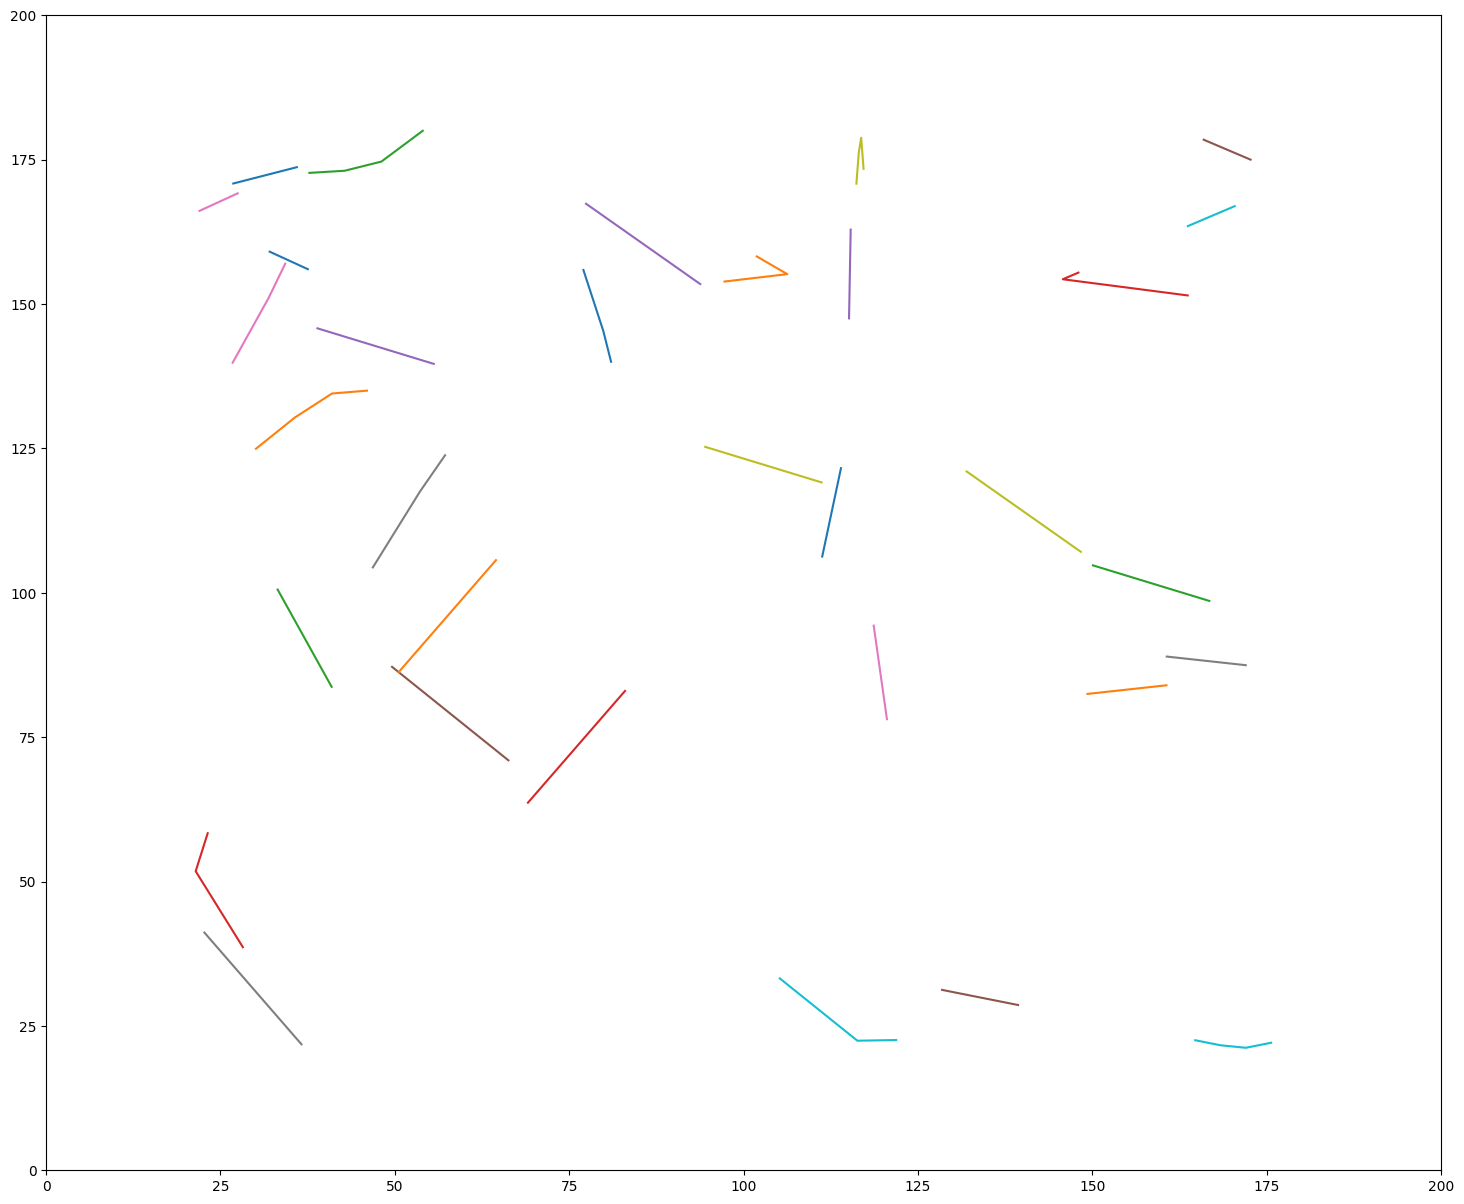

In [4]:
if __name__ == "__main__":
    dataset = NBodyDataset(
        dataset="nbody-4",
        input_steps=4,
        output_steps=20,
        time_interval=4,
        is_y_diff=False,
        is_train=True,
        show_missing_files=False,
        is_testdata=False,
    )
    data=dataset.get(0)
    is_visualize = True
    start_t = 0
    n_bodies = eval(dataset.dataset.split("-")[1])
    if is_visualize:
        import matplotlib.pylab as plt
        plt.figure(figsize=(18,15))
        for i in range(8):
            data = dataset[i*10+start_t]
            for j in range(n_bodies):
                plt.plot(data.x[j,:,0], data.x[j,:,1])
            plt.xlim([0,200])
            plt.ylim([0,200])
        plt.show()